# Prophet

In [130]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Zasada działania

In [131]:
data = pd.read_csv("../data/mg.dat", sep=" ", index_col=0, names=["y"])
data["ds"] = pd.date_range(start="01-01-2000", periods=data.shape[0], freq="D")
data.head(6)

,y,ds
0,1.200000,2000-01-01
1,1.085805,2000-01-02
2,0.982477,2000-01-03
3,0.888982,2000-01-04
4,0.804384,2000-01-05
5,0.727837,2000-01-06


### Model

[towrdsdatascience](https://towardsdatascience.com/time-series-analysis-with-facebook-prophet-how-it-works-and-how-to-use-it-f15ecf2c0e3a)

[dokumentacja](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

Tworzymy instancję klasy `Prophet` i fitujemy ją do danych. Następnie wykorzystujemy metodę `make_future_dataframe` do zbudowania listy dat w której znajdują się daty z okresu dla której mamy dane oraz daty przyszłe zgodnie z podanymi parametrami. Metoda `predict` pozwala na przwidzenie danych dla dat z `future`.

[hipermarametry](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning)

Do klasy `Prophet` możemy podać informację na temat szcególnych dni (święta, lockdown, itd.) w parametrze `holidays` jako DataFrame z dwoma kolumnami: `ds` - daty, `holiday` - nazwa święta.

Dane wejściowe do treningu to DataFrame z dwoma kolumnami: `ds` - daty, `y` - wartości

In [132]:
m = Prophet()
m.fit(data)

17:46:51 - cmdstanpy - INFO - Chain [1] start processing
17:46:51 - cmdstanpy - INFO - Chain [1] done processing


In [133]:
future = m.make_future_dataframe(periods=365, freq="D")
future

,ds
0,2000-01-01
1,2000-01-02
2,2000-01-03
3,2000-01-04
4,2000-01-05
...,...
1561,2004-04-10
1562,2004-04-11
1563,2004-04-12
1564,2004-04-13


In [134]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1561,2004-04-10,0.919850,0.606831,1.206068
1562,2004-04-11,0.919706,0.619024,1.206734
1563,2004-04-12,0.919153,0.649114,1.235673
1564,2004-04-13,0.918146,0.602720,1.176428
1565,2004-04-14,0.916590,0.626627,1.200623


### Wizualizacja

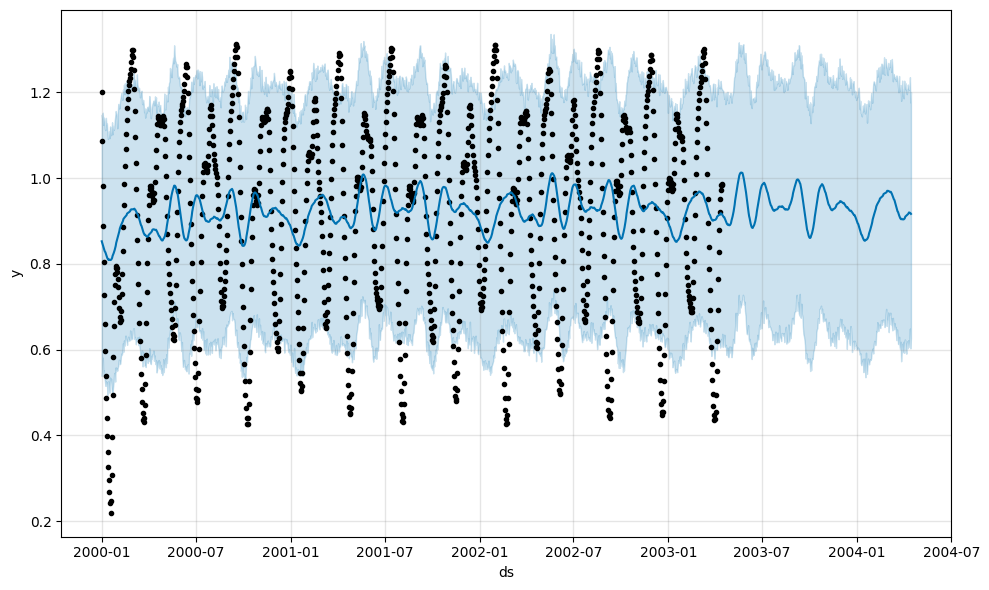

In [135]:
fig1 = m.plot(forecast)

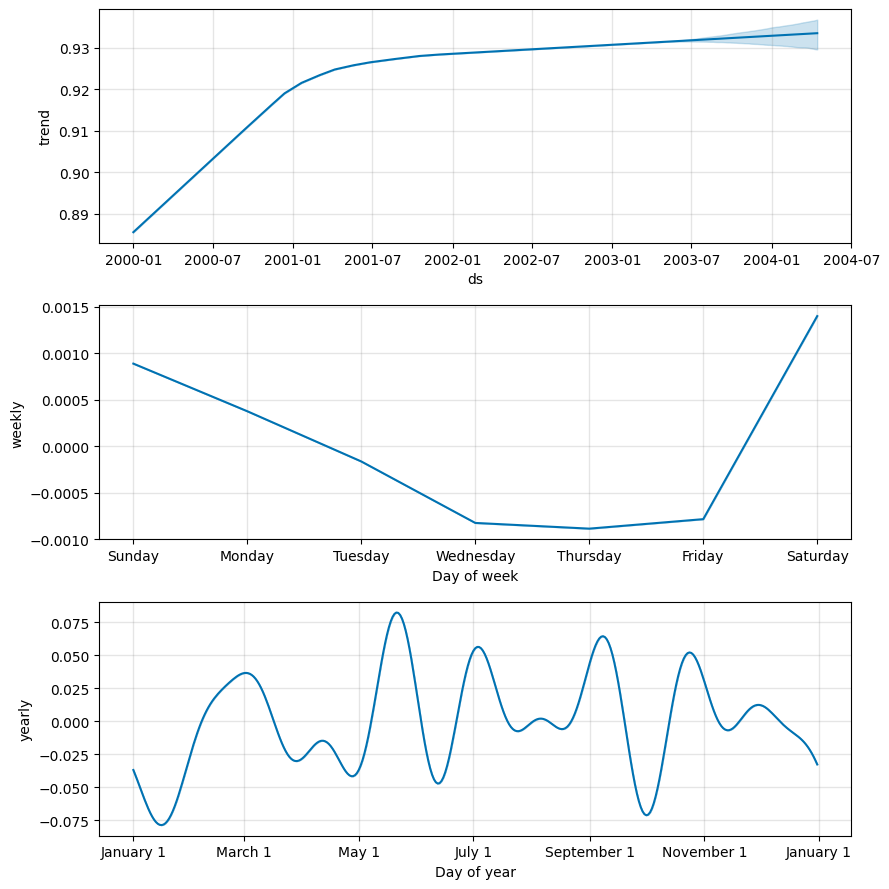

In [136]:
fig2 = m.plot_components(forecast)

Poniżej interaktywne wykresy `plotly`.

In [137]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [138]:
plot_components_plotly(m, forecast)

### Walidacja krzyżowa

Poszukiwanie najlepszych hiperparametrów.

In [139]:
import itertools
from prophet.diagnostics import performance_metrics, cross_validation

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(data)  # Fit model with given params
    df_cv = cross_validation(m, initial='700 days', period='100 days', horizon='100 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

17:46:58 - cmdstanpy - INFO - Chain [1] start processing
17:46:58 - cmdstanpy - INFO - Chain [1] done processing
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
17:47:01 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
17:47:01 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  0.313997
1                     0.001                     0.10  0.357225
2                     0.001                     1.00  0.360636
3                     0.001                    10.00  0.358090
4                     0.010                     0.01  0.290530
5                     0.010                     0.10  0.336280
6                     0.010                     1.00  0.337283
7                     0.010                    10.00  0.336833
8                     0.100                     0.01  0.290304
9                     0.100                     0.10  0.336024
10                    0.100                     1.00  0.336641
11                    0.100                    10.00  0.336767
12                    0.500                     0.01  0.291206
13                    0.500                     0.10  0.337946
14                    0.500                     1.00  0

In [140]:
m = Prophet(**best_params).fit(data)  # Fit model with given params
df_cv = cross_validation(m, initial='700 days', period='100 days', horizon='100 days', parallel="processes")
df_cv

17:47:43 - cmdstanpy - INFO - Chain [1] start processing
17:47:43 - cmdstanpy - INFO - Chain [1] done processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2001-12-02,0.830761,0.597110,1.071210,1.033001,2001-12-01
1,2001-12-03,0.834885,0.563984,1.077345,1.026813,2001-12-01
2,2001-12-04,0.839646,0.586560,1.078334,1.020815,2001-12-01
3,2001-12-05,0.845393,0.607244,1.085026,1.017924,2001-12-01
4,2001-12-06,0.852027,0.584515,1.099395,1.021163,2001-12-01
...,...,...,...,...,...,...
495,2003-04-11,0.928932,0.635622,1.221042,0.951448,2003-01-05
496,2003-04-12,0.924534,0.624947,1.192495,0.971623,2003-01-05
497,2003-04-13,0.918194,0.622163,1.198207,0.982832,2003-01-05
498,2003-04-14,0.911577,0.620163,1.205431,0.986405,2003-01-05


In [141]:
df_p = performance_metrics(df_cv, rolling_window=1)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,100 days,0.084276,0.290304,0.248426,0.310843,0.240792,0.277585,0.622


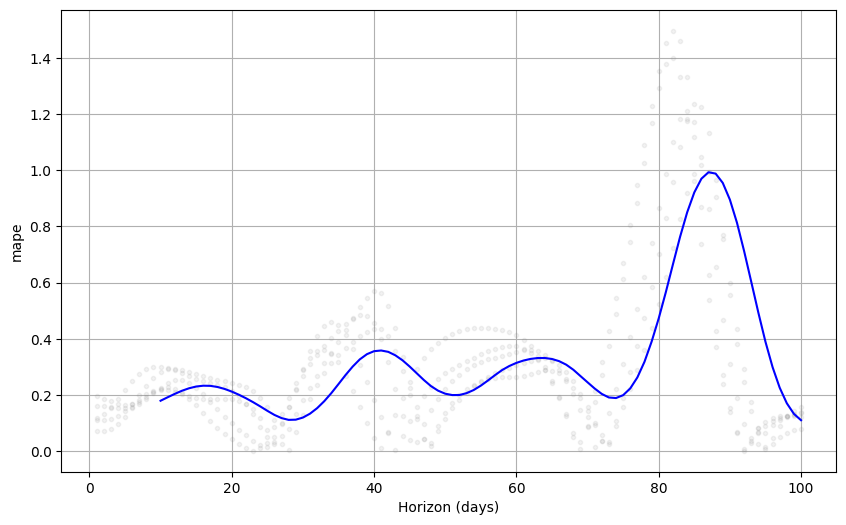

In [142]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

Wykres powyżej pokazuje błąd w procenatch. Punkty to błąd dla kolejnych okien czasowych, niebieska linia to MAPE. Widać że błąd sięga w pewnym momencie 100%.

## Porównanie dla kilku zbiorów danych

In [143]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation

### Mackey Glass

In [144]:
data = pd.read_csv("../data/mg.dat", sep=" ", index_col=0, names=["y"])
data["ds"] = pd.date_range(start="01-01-2000", periods=data.shape[0], freq="D")

In [145]:
test_df = data.loc[data.index >= 801].copy()
train_df =  data.loc[data.index < 801].copy()

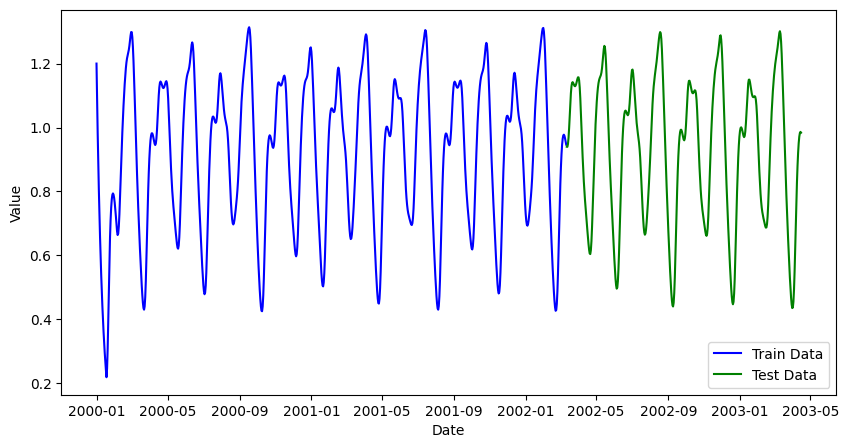

In [146]:
plt.figure(figsize=(10, 5))
plt.plot(train_df.ds, train_df.y, label="Train Data", color='blue')
plt.plot(test_df.ds, test_df.y, label="Test Data", color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [147]:
import itertools

cv_data = data.copy()

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(cv_data)  # Fit model with given params
    df_cv = cross_validation(m, initial='800 days', period='100 days', horizon='300 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
17:47:51 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1] done processing
17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing
17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
5                     0.001                     1.00   multiplicative   
6                     0.001                    10.00         additive   
7                     0.001                    10.00   multiplicative   
8                     0.010                     0.01         additive   
9                     0.010                     0.01   multiplicative   
10                    0.010                     0.10         additive   
11                    0.010                     0.10   multiplicative   
12                    0.010                     1.0

In [148]:
m = Prophet(**best_params)
m.fit(train_df)

future = data[["ds"]]
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

17:49:15 - cmdstanpy - INFO - Chain [1] start processing
17:49:15 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
1196,2003-04-11,0.938458,0.670018,1.248101
1197,2003-04-12,0.939203,0.652196,1.228780
1198,2003-04-13,0.937871,0.659946,1.231585
1199,2003-04-14,0.936011,0.653343,1.221607
1200,2003-04-15,0.933460,0.637050,1.195563


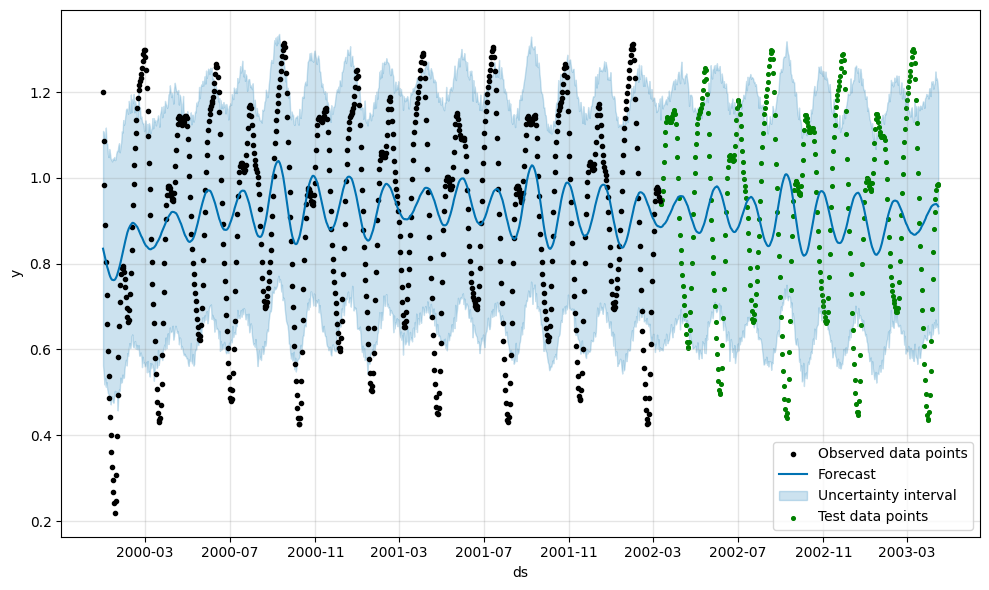

In [149]:
fig1 = m.plot(forecast)
plt.scatter(test_df["ds"], test_df["y"], c="green", s=7, label="Test data points")
plt.legend()
plt.show()

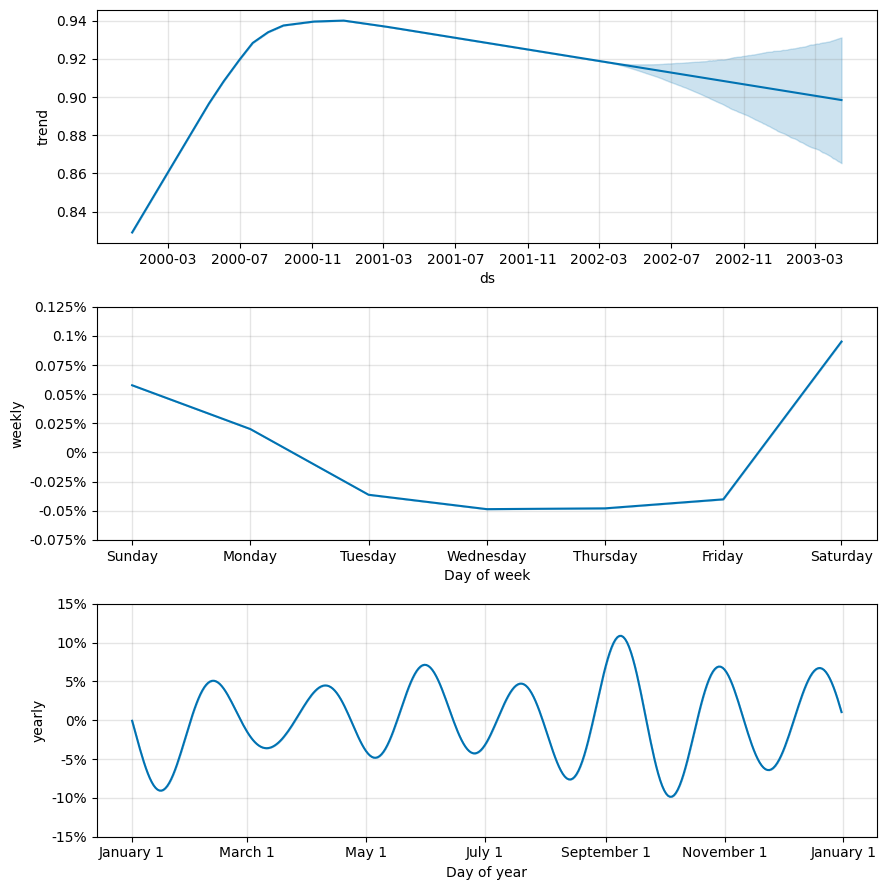

In [150]:
fig2 = m.plot_components(forecast)

10 days horizon - rmse = 0.1639
50 days horizon - rmse = 0.1978
100 days horizon - rmse = 0.242
200 days horizon - rmse = 0.2579
300 days horizon - rmse = 0.2628


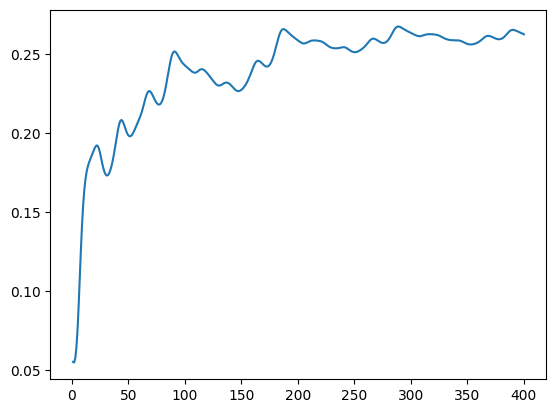

In [151]:
se = (forecast.loc[test_df.index]["yhat"] - test_df["y"]) ** 2
predicted_days = np.arange(1, se.shape[0]+1)
rmse = np.sqrt(np.cumsum(se) / predicted_days).values

for h in [10, 50, 100, 200, 300]:
    print(f"{h} days horizon - rmse = {round(rmse[h], 4)}")

plt.plot(predicted_days, rmse)
plt.show()

### Sunspots

In [152]:
data = pd.read_csv("../data/Sunspots.csv", index_col=0)
data.columns = ["ds", "y"]
data

,ds,y
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
...,...,...
3260,2020-09-30,0.6
3261,2020-10-31,14.4
3262,2020-11-30,34.0
3263,2020-12-31,21.8


In [153]:
pivot = int(data.shape[0] * 0.75)
test_df = data.loc[data.index >= pivot].copy()
train_df =  data.loc[data.index < pivot].copy()

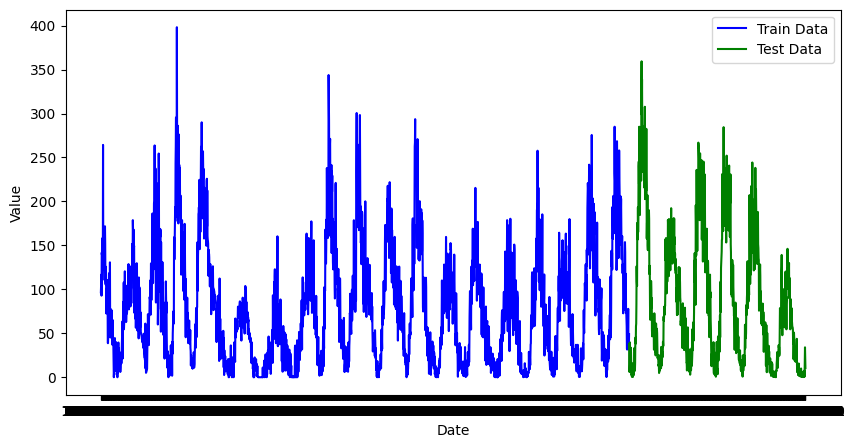

In [154]:
plt.figure(figsize=(10, 5))
plt.plot(train_df.ds, train_df.y, label="Train Data", color='blue')
plt.plot(test_df.ds, test_df.y, label="Test Data", color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [155]:
LIMIT = 1200
cv_data = data.iloc[:LIMIT]
print(cv_data)
print(cv_data.iloc[800])
print(cv_data.iloc[-24])

              ds      y
0     1749-01-31   96.7
1     1749-02-28  104.3
2     1749-03-31  116.7
3     1749-04-30   92.8
4     1749-05-31  141.7
...          ...    ...
1195  1848-08-31  220.9
1196  1848-09-30  167.3
1197  1848-10-31  220.6
1198  1848-11-30  191.0
1199  1848-12-31  265.8

[1200 rows x 2 columns]
ds    1815-09-30
y           52.5
Name: 800, dtype: object
ds    1847-01-31
y          104.4
Name: 1176, dtype: object


In [156]:
cutoffs = pd.date_range(start=cv_data.iloc[800]["ds"], end=cv_data.iloc[-24]["ds"], freq='12M')
cutoffs

DatetimeIndex(['1815-09-30', '1816-09-30', '1817-09-30', '1818-09-30',
               '1819-09-30', '1820-09-30', '1821-09-30', '1822-09-30',
               '1823-09-30', '1824-09-30', '1825-09-30', '1826-09-30',
               '1827-09-30', '1828-09-30', '1829-09-30', '1830-09-30',
               '1831-09-30', '1832-09-30', '1833-09-30', '1834-09-30',
               '1835-09-30', '1836-09-30', '1837-09-30', '1838-09-30',
               '1839-09-30', '1840-09-30', '1841-09-30', '1842-09-30',
               '1843-09-30', '1844-09-30', '1845-09-30', '1846-09-30'],
              dtype='datetime64[ns]', freq='12M')

In [157]:
import itertools


param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(cv_data)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='700 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
17:50:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:18 - cmdstanpy - INFO - Chain [1] done processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] done processing
17:50:19 - cmdstanpy - INFO - Chain [1] done processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] done p

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
5                     0.001                     1.00   multiplicative   
6                     0.001                    10.00         additive   
7                     0.001                    10.00   multiplicative   
8                     0.010                     0.01         additive   
9                     0.010                     0.01   multiplicative   
10                    0.010                     0.10         additive   
11                    0.010                     0.10   multiplicative   
12                    0.010                     1.0

In [158]:
m = Prophet(**best_params, weekly_seasonality=False, daily_seasonality=False)
m.fit(train_df)

future = data[["ds"]]
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

17:58:38 - cmdstanpy - INFO - Chain [1] start processing
17:58:38 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
3260,2020-09-30,53.425099,-30.398570,136.655823
3261,2020-10-31,53.522684,-36.005279,141.859173
3262,2020-11-30,53.455131,-30.943506,131.623165
3263,2020-12-31,53.400830,-35.459532,138.567458
3264,2021-01-31,52.972386,-40.430084,140.340182


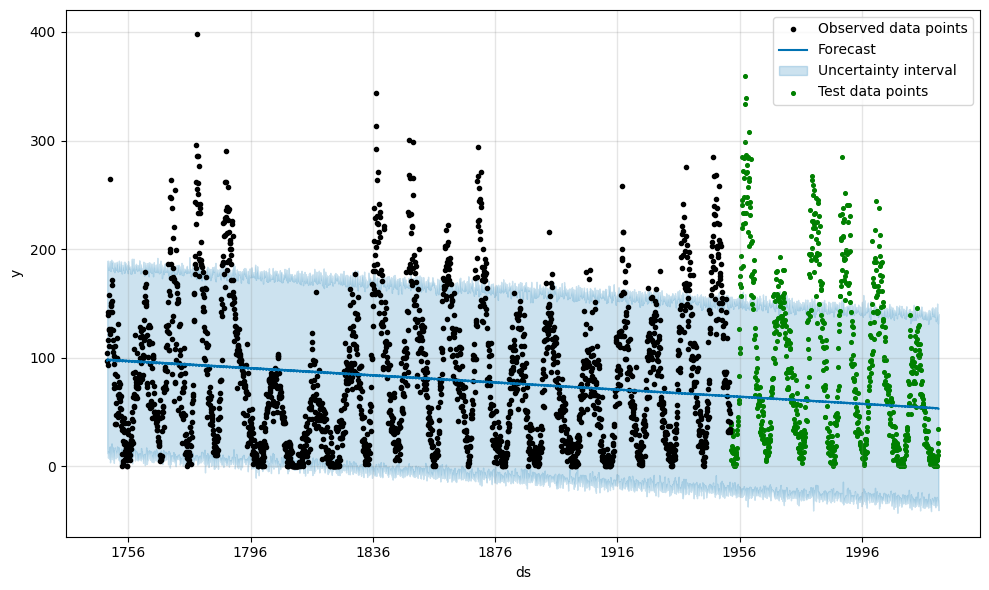

In [159]:
fig1 = m.plot(forecast)
plt.scatter(test_df["ds"], test_df["y"], c="green", s=7, label="Test data points")
plt.legend()
plt.show()

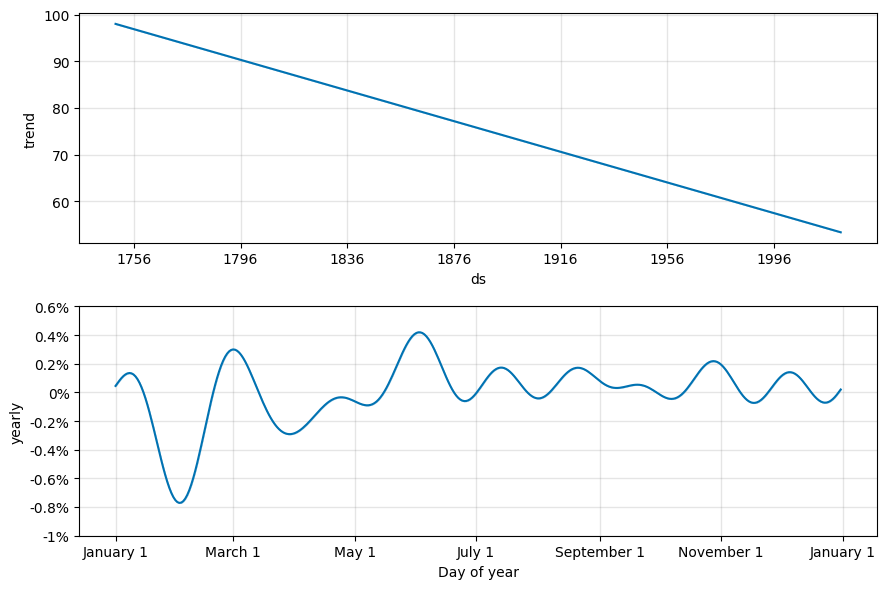

In [160]:
fig2 = m.plot_components(forecast)

10 days horizon - rmse = 44.7113
50 days horizon - rmse = 89.1324
100 days horizon - rmse = 133.6141
200 days horizon - rmse = 102.6051
300 days horizon - rmse = 87.8844


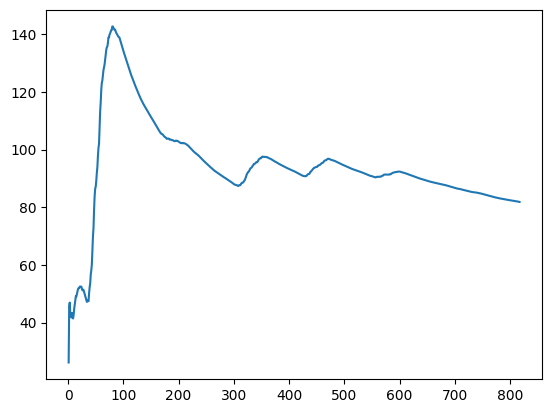

In [161]:
se = (forecast.loc[test_df.index]["yhat"] - test_df["y"]) ** 2
predicted_days = np.arange(1, se.shape[0]+1)
rmse = np.sqrt(np.cumsum(se) / predicted_days).values

for h in [10, 50, 100, 200, 300]:
    print(f"{h} days horizon - rmse = {round(rmse[h], 4)}")

plt.plot(predicted_days, rmse)
plt.show()

### Electricity

In [162]:
data = pd.read_csv("../data/electricity_consumption_dataset.csv")
data["ds"] = [pd.Timestamp(f"{d} {t}") for d, t in zip(data["Date"], data["Time"])]
data["y"] = data["Consumption Amount (MWh)"].apply(lambda x: float(x.replace(".", "").replace(",",".")))
data = data[["ds", "y"]].sort_values(["ds"]).reset_index(drop=True)
data

,ds,y
0,2015-12-31 00:00:00,29590.88
1,2015-12-31 01:00:00,27785.43
2,2015-12-31 02:00:00,26516.53
3,2015-12-31 03:00:00,26091.62
4,2015-12-31 04:00:00,25871.54
...,...,...
39451,2020-12-06 19:00:00,33328.32
39452,2020-12-06 20:00:00,34326.80
39453,2020-12-06 21:00:00,34294.81
39454,2020-12-06 22:00:00,33305.15


In [163]:
pivot = int(data.shape[0] * 0.75)
test_df = data.iloc[data.index >= pivot].copy()
train_df =  data.iloc[data.index < pivot].copy()

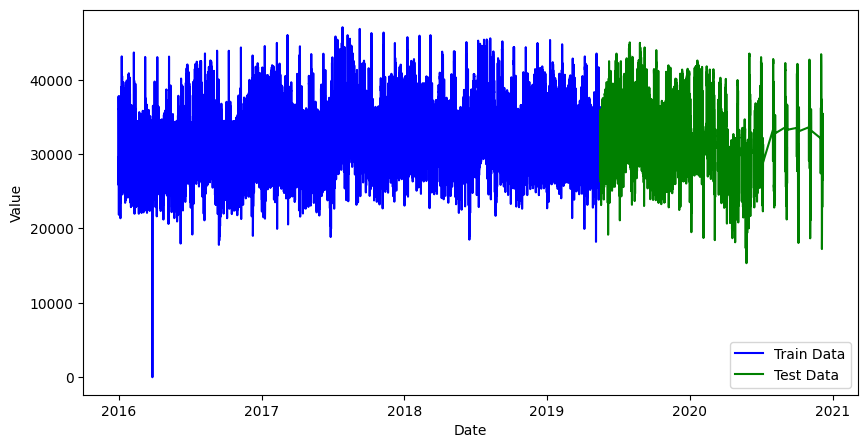

In [164]:
plt.figure(figsize=(10, 5))
plt.plot(train_df.ds, train_df.y, label="Train Data", color='blue')
plt.plot(test_df.ds, test_df.y, label="Test Data", color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [165]:
LIMIT = 1300
cv_data = data.iloc[:LIMIT]
print(cv_data)
print(cv_data.iloc[800])
print(cv_data.iloc[-240])

                      ds         y
0    2015-12-31 00:00:00  29590.88
1    2015-12-31 01:00:00  27785.43
2    2015-12-31 02:00:00  26516.53
3    2015-12-31 03:00:00  26091.62
4    2015-12-31 04:00:00  25871.54
...                  ...       ...
1295 2016-02-22 23:00:00  30219.48
1296 2016-02-23 00:00:00  27972.52
1297 2016-02-23 01:00:00  26367.45
1298 2016-02-23 02:00:00  25288.39
1299 2016-02-23 03:00:00  24790.77

[1300 rows x 2 columns]
ds    2016-02-02 08:00:00
y                 32338.9
Name: 800, dtype: object
ds    2016-02-13 04:00:00
y                 25457.1
Name: 1060, dtype: object


In [166]:
cutoffs = pd.date_range(start=cv_data.iloc[800]["ds"], end=cv_data.iloc[-240]["ds"], freq='5D')
cutoffs

DatetimeIndex(['2016-02-02 08:00:00', '2016-02-07 08:00:00',
               '2016-02-12 08:00:00'],
              dtype='datetime64[ns]', freq='5D')

In [167]:
import itertools


param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(cv_data)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

17:58:58 - cmdstanpy - INFO - Chain [1] start processing
17:58:58 - cmdstanpy - INFO - Chain [1] done processing
17:58:59 - cmdstanpy - INFO - Chain [1] start processing
17:58:59 - cmdstanpy - INFO - Chain [1] start processing
17:58:59 - cmdstanpy - INFO - Chain [1] start processing
17:58:59 - cmdstanpy - INFO - Chain [1] done processing
17:58:59 - cmdstanpy - INFO - Chain [1] done processing
17:58:59 - cmdstanpy - INFO - Chain [1] done processing
17:59:00 - cmdstanpy - INFO - Chain [1] start processing
17:59:00 - cmdstanpy - INFO - Chain [1] done processing
17:59:01 - cmdstanpy - INFO - Chain [1] start processing
17:59:01 - cmdstanpy - INFO - Chain [1] start processing
17:59:01 - cmdstanpy - INFO - Chain [1] start processing
17:59:01 - cmdstanpy - INFO - Chain [1] done processing
17:59:01 - cmdstanpy - INFO - Chain [1] done processing
17:59:01 - cmdstanpy - INFO - Chain [1] done processing
17:59:02 - cmdstanpy - INFO - Chain [1] start processing
17:59:03 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
5                     0.001                     1.00   multiplicative   
6                     0.001                    10.00         additive   
7                     0.001                    10.00   multiplicative   
8                     0.010                     0.01         additive   
9                     0.010                     0.01   multiplicative   
10                    0.010                     0.10         additive   
11                    0.010                     0.10   multiplicative   
12                    0.010                     1.0

In [168]:
m = Prophet(**best_params)
m.fit(train_df)

future = data[["ds"]]
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

18:01:08 - cmdstanpy - INFO - Chain [1] start processing
18:01:17 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
39451,2020-12-06 19:00:00,33202.064261,28986.703234,37164.117589
39452,2020-12-06 20:00:00,33411.288012,29526.545425,37642.132294
39453,2020-12-06 21:00:00,33318.735299,29321.890317,37494.437102
39454,2020-12-06 22:00:00,32482.953883,28378.135363,36364.870850
39455,2020-12-06 23:00:00,30951.059917,27142.669349,34943.028891


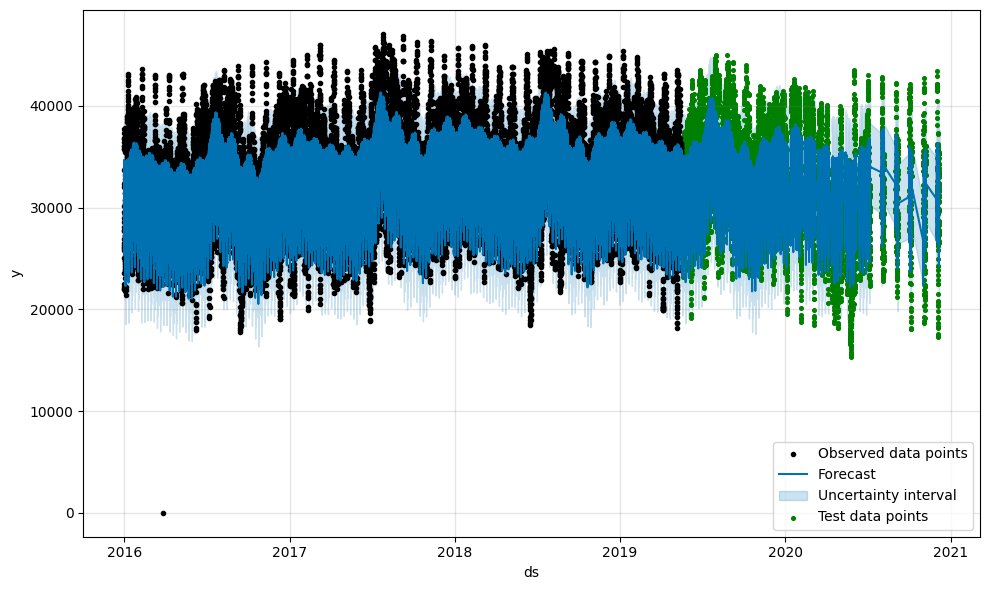

In [169]:
fig1 = m.plot(forecast)
plt.scatter(test_df["ds"], test_df["y"], c="green", s=7, label="Test data points")
plt.legend()
plt.show()

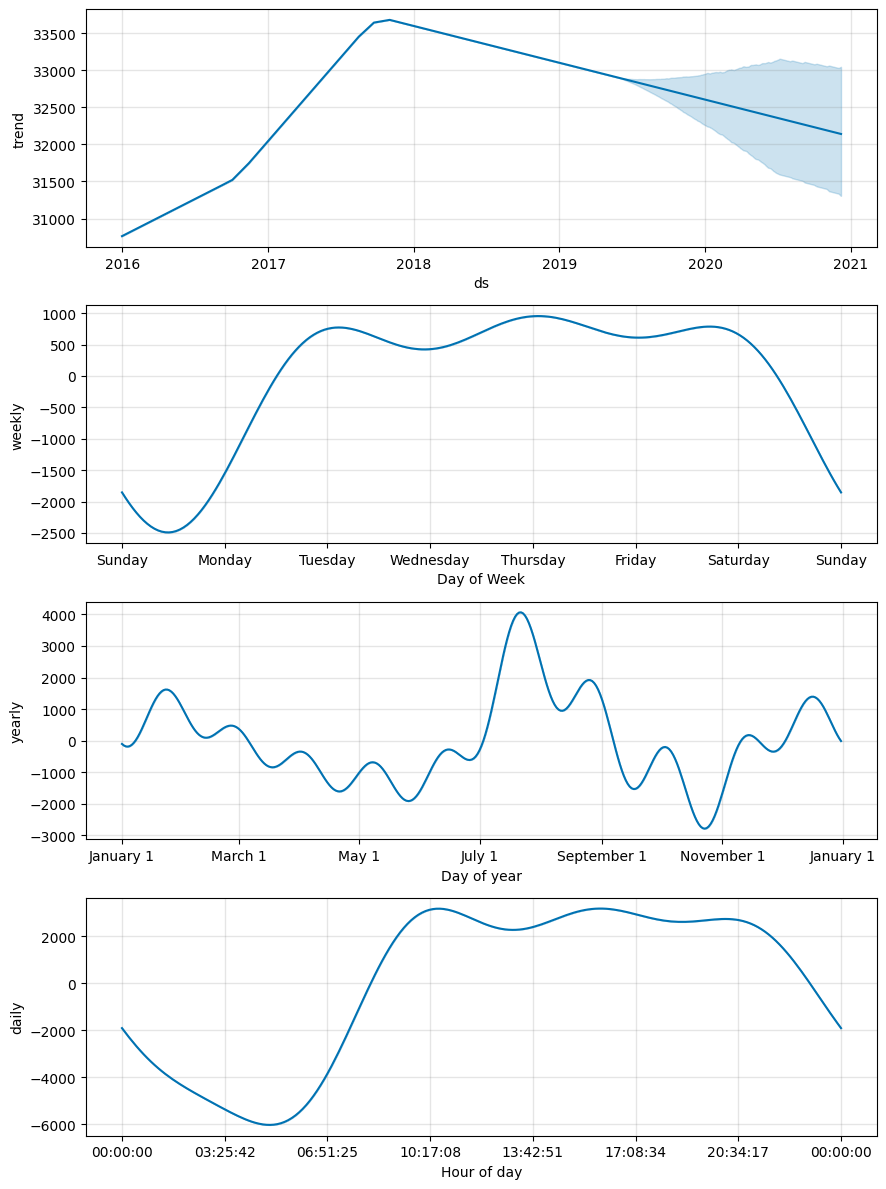

In [170]:
fig2 = m.plot_components(forecast)

10 days horizon - rmse = 1882.8905
50 days horizon - rmse = 1818.7503
100 days horizon - rmse = 2268.3825
200 days horizon - rmse = 2317.2717
300 days horizon - rmse = 2502.2103


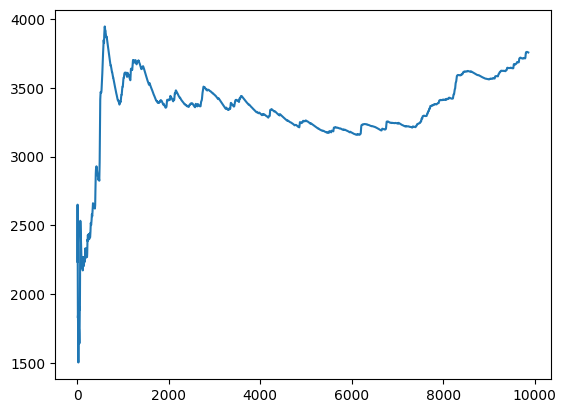

In [171]:
se = (forecast.loc[test_df.index]["yhat"] - test_df["y"]) ** 2
predicted_days = np.arange(1, se.shape[0]+1)
rmse = np.sqrt(np.cumsum(se) / predicted_days).values

for h in [10, 50, 100, 200, 300]:
    print(f"{h} days horizon - rmse = {round(rmse[h], 4)}")

plt.plot(predicted_days, rmse)
plt.show()